<a href="https://colab.research.google.com/github/kusandriadi/wgan_batik/blob/main/generate_batik_WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [4]:
#for targz
url = 'https://raw.githubusercontent.com/kusandriadi/wgan_batik/main/Batik300.tar.gz'
!curl {url} | tar xz

#for zip
#!wget https://raw.githubusercontent.com/kusandriadi/wgan_batik/main/Batik300.zip
#!unzip /content/Batik300.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5230k  100 5230k    0     0  11.3M      0 --:--:-- --:--:-- --:--:-- 11.4M


In [5]:
#load all *.jpg images from directory
image_paths = glob.glob('/content/Batik300/*.jpg')

#count images
len(image_paths)

300

In [6]:
def load_preprosess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.cast(img, tf.float32)
    img = img / 255
    img = img * 2 - 1
    img = img

    return img

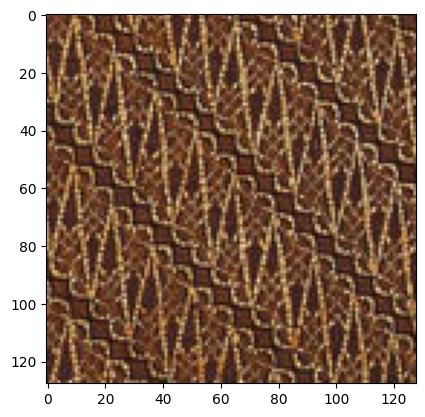

In [7]:
plt.imshow((load_preprosess_image(image_paths[0]).numpy()+1)/2)

In [8]:
image_ds = tf.data.Dataset.from_tensor_slices(image_paths)

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)

In [10]:
BATCH_SIZE = 128
latent_dim = 100
Shuffle_parameter = len(image_paths)

image_ds = image_ds.shuffle(Shuffle_parameter).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [11]:
image_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)>

In [12]:
image_ds.__len__()

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [13]:
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(4 * 4 * 512, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))

    return model

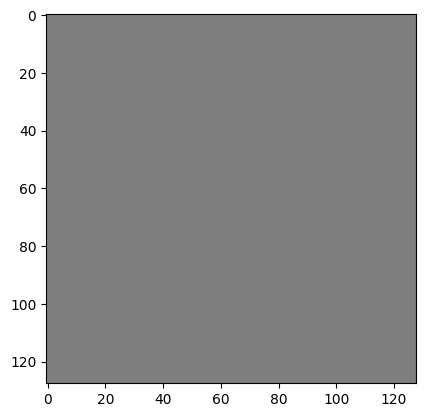

In [14]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(((generated_image[0, :, :, :])+1)/2)

In [15]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=[128,128,3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-5.7200465e-05]], shape=(1, 1), dtype=float32)


In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = -real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    fake_loss = tf.reduce_mean(fake_output)
    return -fake_loss

In [18]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

In [19]:
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:
def image_show():

    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :3] + 1)/2)
        plt.axis('off')
    plt.show()

    return predictions

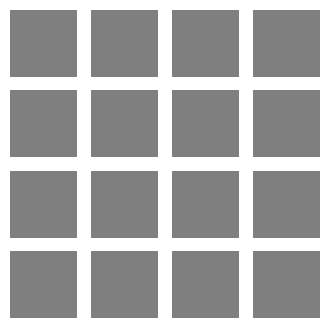

In [21]:
pred = image_show()

In [22]:
@tf.function
def train_discriminator(batch_imgs):
    batch_size = batch_imgs.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as discriminator_tape:

        real_output = discriminator(batch_imgs,training=True)
        generated_images = generator(noise,training=True)
        fake_output = discriminator(generated_images,training=True)

        disc_loss = discriminator_loss(real_output,fake_output)

    discriminator_grads = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

    # weight clipping
    for idx, weight in enumerate(discriminator.weights):
        discriminator.weights[idx] = tf.clip_by_value(weight,-0.01,0.01)


In [23]:
@tf.function
def train_generator(batch_imgs):
    batch_size = batch_imgs.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as generator_tape:
        generated_images = generator(noise,training=True)
        fake_output = discriminator(generated_images,training=True)

        gen_loss = generator_loss(fake_output)

    generator_grads = generator_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

In [24]:
Evolutionary_history = []

In [25]:
for epoch in range(EPOCHS):

    for batch_imgs in image_ds:
        train_discriminator(batch_imgs)
        train_generator(batch_imgs)

    if (epoch+1)%10 == 0:
        cache = image_show()
        Evolutionary_history.append(cache)

KeyboardInterrupt: ignored

In [ ]:
len(Evolutionary_history)

In [ ]:
for predictions in Evolutionary_history:

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :3] + 1)/2)
        plt.axis('off')
    plt.show()